# Apr 3rd, 2022 (copy files: rabies + ca)

**Motivation**: Copied files to raw dir.  Now have: runs, masks, anat images, all in place. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Copy CA files

In [5]:
mice = Mice(128)

In [11]:
raw_new = '/mnt/storage/hadi/Ca-fMRI/raw_new'

for f in sorted(os.listdir(mice.cfg.raw_dir)):
    if 'ca2' not in f:
        continue
    if 'referenceimage_ca2' in f:
        if not os.path.isfile(pjoin(raw_new, f)):
            shutil.copyfile(
                src=pjoin(mice.cfg.raw_dir, f),
                dst=pjoin(raw_new, f),
            )

In [23]:
bids = '/mnt/storage/hadi/Ca-fMRI/PreprocessedDataBIDS'
for p in pathlib.Path(bids).rglob('*.nii.gz'):
    if not os.path.isfile(pjoin(raw_new, p.name)):
        shutil.copyfile(
            src=str(p),
            dst=pjoin(raw_new, p.name),
        )

## Load BOLD masks and save session mask

In [115]:
from register.register import reset_ants_img

In [116]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/brain_mask'
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        #if not(sub == 5 and ses == 1):
        #    continue

        key = f"sub-SLC{sub:02d}_ses-{ses}"
        files = sorted(filter(
            lambda x: key in x,
            os.listdir(pth),
        ))
        masks = {}
        for f in files:
            run = next(e for e in f.split('_') if 'run' in e)
            run = int(re.findall(r"\d+", run).pop())
            m = ants.image_read(pjoin(pth, f))
            masks[run] = m.numpy().astype(bool)
        masks = dict(sorted(masks.items()))

        for i, m1 in masks.items():
            for j, m2 in masks.items():
                if not np.array_equal(m1, m2):
                    print('Warning, unmatched masks detected')
                    print(i, j, overlap_score(m1, m2), dice_score(m1, m2), np.array_equal(m1, m2))

        m_ses = reset_ants_img(
            img=list(masks.values())[0],
            spacing=m.spacing,
            origin=m.origin,
            dtype='uint32',
            use_um=False,
        )
        name = f"{key}_space-individual_desc-mask_bold.nii.gz"
        filename = pjoin(raw_new, name)
        if not os.path.isfile(filename):
            ants.image_write(m_ses, filename)
        else:
            print(f"File found, skipping:\n'{name}'\n")

## Copy isotropic T1w

In [120]:
for f in sorted(os.listdir(mice.cfg.raw_dir)):
    if 'isotropic' not in f:
        continue
    if not os.path.isfile(pjoin(raw_new, f)):
        shutil.copyfile(
            src=pjoin(mice.cfg.raw_dir, f),
            dst=pjoin(raw_new, f),
        )

## Copy RABIES (raw + cleaned)

In [137]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/native_preprocessed_data'
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        key = f"sub-SLC{sub:02d}_ses-{ses}"
        files = sorted(filter(
            lambda x: key in x,
            os.listdir(pth),
        ))
        for f in files:
            name = '_'.join(f.split('_')[:4])
            name = f"{name}_space-individual_desc-raw_bold.nii.gz"
            filename = pjoin(raw_new, name)
            if not os.path.isfile(filename):
                shutil.copyfile(
                    src=pjoin(pth, f),
                    dst=filename,
                )
            else:
                print(f"File found, skipping:\n'{name}'\n")

In [138]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data/cleaned_timeseries'
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        key = f"sub-SLC{sub:02d}_ses-{ses}"
        files = sorted(filter(
            lambda x: key in x,
            os.listdir(pth),
        ))
        for f in files:
            name = '_'.join(f.split('_')[:4])
            name = f"{name}_space-individual_desc-rabies_bold.nii.gz"
            filename = pjoin(raw_new, name)
            if not os.path.isfile(filename):
                shutil.copyfile(
                    src=pjoin(pth, f),
                    dst=filename,
                )
            else:
                print(f"File found, skipping:\n'{name}'\n")

## Test mask/T1w alignment

In [191]:
t1w, masks = {}, {}
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        key = f"sub-SLC{sub:02d}_ses-{ses}"
        files = sorted(filter(
            lambda x: key in x,
            os.listdir(raw_new),
        ))
        f = next(e for e in files if 'T1w' in e)
        t1w[key] = ants.image_read(pjoin(raw_new, f)).numpy()
        f = next(e for e in files if 'mask' in e)
        masks[key] = ants.image_read(pjoin(raw_new, f)).numpy().astype(bool)

In [239]:
save_dir = pjoin(fig_dir, 'quality_control')
os.makedirs(save_dir, exist_ok=True)

save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control'

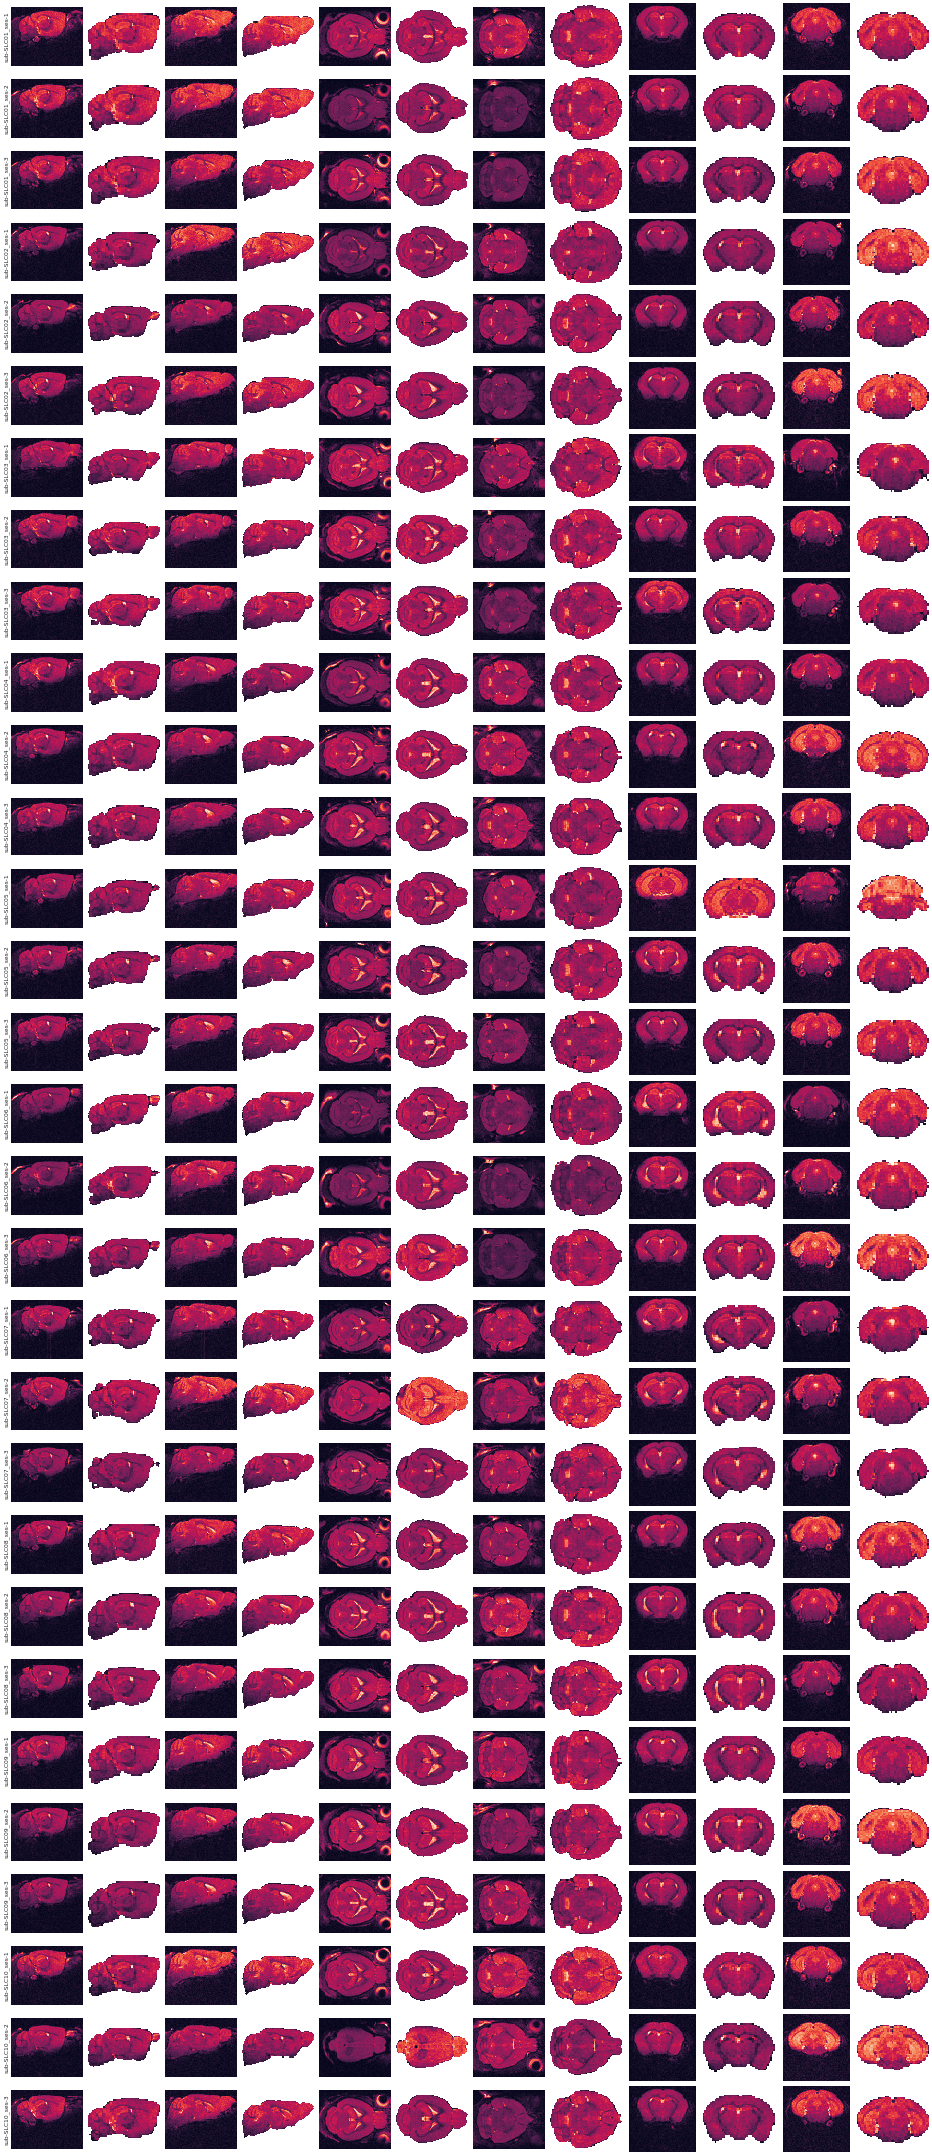

In [240]:
slices = [20, 13, 38]
slices_delta = [15, 10, -12]

nrows = len(t1w)
fig, axes = create_figure(nrows, 12, (26, 2.0 * nrows), dpi=36)

for i, (k, x) in enumerate(t1w.items()):
    m = masks[k]
    axes[i, 0].set_ylabel(k, fontsize=12)
    for j, sl in enumerate(slices):
        ax = axes[i, 4 * j]
        x2p = np.take(x, sl, j)
        ax.imshow(x2p.T if j == 2 else x2p)
        
        ax = axes[i, 4 * j + 1]
        m2p = np.take(m, sl, j)
        x2p = np.take(x, sl, j)
        x2p, m2p = filter_boundaries([x2p, m2p], m2p)
        x2p = mwh(m2p == 0, x2p)
        ax.imshow(x2p.T if j == 2 else x2p)

        ax = axes[i, 4 * j + 2]
        x2p = np.take(x, sl + slices_delta[j], j)
        ax.imshow(x2p.T if j == 2 else x2p)
        
        ax = axes[i, 4 * j + 3]
        m2p = np.take(m, sl + slices_delta[j], j)
        x2p = np.take(x, sl + slices_delta[j], j)
        x2p, m2p = filter_boundaries([x2p, m2p], m2p)
        x2p = mwh(m2p == 0, x2p)
        ax.imshow(x2p.T if j == 2 else x2p)
remove_ticks(axes)
fig.savefig(pjoin(save_dir, 'T1w_vs_masks.pdf'), bbox_inches='tight')
plt.show()

## Temporal mask

### Previous one

In [147]:
pth = '/home/hadi/Documents/Ca-fMRI/meta_info'
df = pd.read_pickle(pjoin(pth, 'temporal_mask.df'))
present = df['key'].unique()

for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        for run in range(1, 7 + 1):
            key = f"sub-SLC{sub:02d}_ses-{ses}_run-{run}"
            if key not in present:
                print(key)

sub-SLC03_ses-1_run-1

sub-SLC03_ses-3_run-2

sub-SLC04_ses-3_run-2

sub-SLC05_ses-1_run-5

sub-SLC06_ses-3_run-2

sub-SLC07_ses-1_run-6

sub-SLC08_ses-1_run-7

### Make new

In [152]:
pth = '/mnt/storage/hadi/Ca-fMRI/gabe_data/reoriented_data'
csv_files = []
for p in pathlib.Path(pth).rglob('*.csv'):
    csv_files.append(str(p))
    
meta_dir = pjoin(mice.cfg.base_dir, 'meta_info')

dlist = []
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        for run in range(1, 7 + 1):
            patterns = [
                f"sub-SLC{sub:02d}",
                f"ses-{ses:d}",
                f"run-{run:d}",
            ]
            key = '_'.join(patterns)
            try:
                f = next(
                    e for e in csv_files if
                    all(k in e for k in patterns)
                )
                vals = pd.read_csv(f).values.ravel()
                dlist.append({
                    'sub': [sub] * len(vals),
                    'ses': [ses] * len(vals),
                    'run': [run] * len(vals),
                    'key': [key] * len(vals),
                    'temporal_mask': vals.astype(int),
                })
            except StopIteration:
                print(f"Warning, missing:\t{key}")

df = pd.DataFrame(merge_dicts(dlist))
_ = save_obj(
    obj=df,
    file_name='temporal_mask',
    save_dir=meta_dir,
    mode='df',
)

Warning, missing:       sub-SLC01_ses-1_run-4

Warning, missing:       sub-SLC03_ses-1_run-1

Warning, missing:       sub-SLC03_ses-3_run-2

Warning, missing:       sub-SLC04_ses-3_run-2

Warning, missing:       sub-SLC05_ses-1_run-5

Warning, missing:       sub-SLC06_ses-3_run-2

Warning, missing:       sub-SLC07_ses-1_run-6

Warning, missing:       sub-SLC07_ses-2_run-1

Warning, missing:       sub-SLC08_ses-1_run-7

[PROGRESS] 'temporal_mask.df' saved at
/home/hadi/Documents/Ca-fMRI/meta_info

In [158]:
pth = '/home/hadi/Documents/Ca-fMRI/meta_info'
df = pd.read_pickle(pjoin(pth, 'temporal_mask.df'))
present = df['key'].unique()
missing = []
for sub in range(1, 10 + 1):
    for ses in range(1, 3 + 1):
        for run in range(1, 7 + 1):
            key = f"sub-SLC{sub:02d}_ses-{ses}_run-{run}"
            if key not in present:
                missing.append(key)
missing

[
    'sub-SLC01_ses-1_run-4',
    'sub-SLC03_ses-1_run-1',
    'sub-SLC03_ses-3_run-2',
    'sub-SLC04_ses-3_run-2',
    'sub-SLC05_ses-1_run-5',
    'sub-SLC06_ses-3_run-2',
    'sub-SLC07_ses-1_run-6',
    'sub-SLC07_ses-2_run-1',
    'sub-SLC08_ses-1_run-7'
]

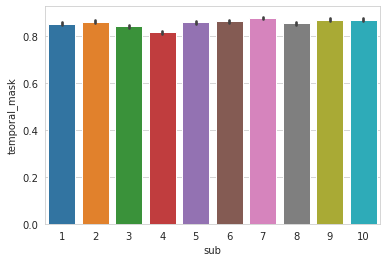

In [159]:
sns.barplot(data=df, x='sub', y='temporal_mask')
plt.show()

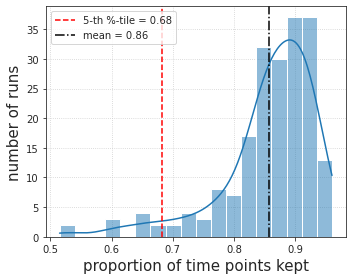

In [160]:
df = df.groupby(['key']).mean()

fig, ax = create_figure(1, 1, (5, 4))

sns.histplot(df, x='temporal_mask', kde=True, ax=ax)
q = df['temporal_mask'].quantile(q=0.05)
ax.axvline(q, color='r', ls='--', label=f'5-th %-tile = {q:0.2f}')
q = df['temporal_mask'].mean()
ax.axvline(q, color='k', ls='-.', label=f'mean = {q:0.2f}')
ax.set_xlabel('proportion of time points kept', fontsize=15)
ax.set_ylabel('number of runs', fontsize=15)
ax.grid()
ax.legend()

plt.show()